In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
sys.path.append("/home/camp/warnert")
sys.path.append("/home/camp/warnert/working/Recordings/binary_pulses/blip_manuscript")
import blip_analysis_manu as ba
import exp_blip_models_manu as em
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe

a


In [17]:
def de_minimisation(coords, true_distances):
    coords = coords[:, np.newaxis]
    #print(coords)

    dm = distance_matrix(coords, coords)
#     dm_off = np.triu(dm, 1)

    loss = np.sum(np.abs(true_distances.ravel() - dm.ravel()))
    return loss

def de_minimisation_across(coords, true_distances, prev_coords, alpha):
    coords = coords[:, np.newaxis]
    
    dm = distance_matrix(coords, coords)
    coords_normed = coords - coords.mean()
    if np.sum((coords - prev_coords)**2) > np.sum((coords + prev_coords)**2):
        coords_diff = np.sum((coords + prev_coords)**2)
    else:
        coords_diff = np.sum((coords - prev_coords)**2)
    loss = np.sum((true_distances.ravel() - dm.ravel())**2) + alpha*coords_diff #+ np.mean(coords)
    return loss

def dask_de_minimisation(true_distances):
    bounds = [[0, 1000]]*32
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[true_distances], popsize=50, tol=0.001, maxiter=10000, )
    coords = de.x
    coords = coords - coords.mean()
    return coords

def flip_distances(distances):
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, len(distances)):
        prev_distance = distances_flipped[-1]
        distance = distances_normed[i]
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    return distances_flipped

def flip_flip_distances(distances):
    flipped_distances = np.array([flip_distances(i) for i in distances])
    flipped_flipped_distances = [flipped_distances[0]]

    for i in range(1, len(flipped_distances)):
        if np.sum(np.abs(flipped_distances[0]+flipped_distances[i])) > np.sum(np.abs(flipped_distances[0]-flipped_distances[i])):
            flipped_flipped_distances.append(flipped_distances[i])
        else:
            flipped_flipped_distances.append(-flipped_distances[i])
    return np.array(flipped_flipped_distances)

def plot_1d_distance_graph(xs, distances, ax, colors=None):
    distances = np.array(distances)
    trial_len = distances.shape[1]
    if colors is None:
        colors = [matplotlib.cm.plasma(i/trial_len) for i in range(trial_len)]

    print(len(colors))
    for index, i in enumerate(distances.T):
        ax.plot(xs, i, color=colors[index])
    ax.axvspan(0, 0.1, color='lightgray')
    
def distance_plots(fig, gs_base, xs, closests):

    sub_gridspec = gs_base.subgridspec(ncols=14, nrows=2, wspace=1.5)
    big_ax = fig.add_subplot(sub_gridspec[0, 2:])
    small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
    small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
    small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
    
    small_ax2.set_yticklabels([])
    small_ax3.set_yticklabels([])
    plot_1d_distance_graph(xs, closests1, big_ax)

    cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
    cbar_ax.yaxis.set_ticks_position('left')
    plot_cbar_and_glyphs(cbar_ax, glyphs)
    cbar_ax.yaxis.set_ticks_position('left')
    plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1)
    plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2)
    plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3)
    
    min_max = np.max(np.abs(np.concatenate([small_ax1.get_ylim(), small_ax2.get_ylim(), small_ax3.get_ylim()])))
    small_ax1.set_ylim(-min_max, min_max)
    small_ax2.set_ylim(-min_max, min_max)
    small_ax3.set_ylim(-min_max, min_max)
    label_ax = fig.add_subplot(sub_gridspec[:, 2:], frameon=False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    label_ax.set_ylabel('Distance (Hz)', labelpad=27)
    label_ax.set_xlabel('Time (s)', labelpad=20)

def plot_cbar_and_glyphs(ax, glyphs, cmap='plasma_r'):
    im = ax.imshow(np.array([[0, 1]]), aspect=30, cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])

In [3]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [4]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [5]:
all_reses = np.load('221027_all_svm_outs.npy')
preds1 = np.array(all_reses)[0, :, 0].reshape(500, 32)
trues1 = np.array(all_reses)[0, :, 1].reshape(500, 32)
preds2 = np.array(all_reses)[1, :, 0].reshape(500, 32)
trues2 = np.array(all_reses)[1, :, 1].reshape(500, 32)
preds3 = np.array(all_reses)[2, :, 0].reshape(500, 32)
trues3 = np.array(all_reses)[2, :, 1].reshape(500, 32)
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))
cm2 = confusion_matrix(np.concatenate(trues2), np.concatenate(preds2), normalize='true', labels=range(32))
cm3 = confusion_matrix(np.concatenate(trues3), np.concatenate(preds3), normalize='true', labels=range(32))

In [6]:
preds_window = np.load('221017_preds_window.npy')
trues_window = np.load('221017_trues_window.npy')
print(preds_window.shape)

(162, 100, 32)


In [7]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt3])
print(mean_usrt2.shape)

(145, 32, 50)


In [9]:
res1 = np.load('221026_de_1d_res_odour1_extended.npy')
res2 = np.load('221027_de_1d_res_odour2_extended.npy')
res3 = np.load('221027_de_1d_res_odour3_extended.npy')
res1 = np.array(res1).reshape(50, 162, 32)
res2 = np.array(res2).reshape(50, 162, 32)
res3 = np.array(res3).reshape(50, 162, 32)

In [11]:
flipped_flipped_distances1 = flip_flip_distances(res1)
flipped_flipped_distances2 = flip_flip_distances(res2)
flipped_flipped_distances3 = flip_flip_distances(res3)

In [12]:
closests1 = [flipped_flipped_distances1[0, 0]]
closests2 = [flipped_flipped_distances2[0, 0]]
closests3 = [flipped_flipped_distances3[0, 0]]
for i in range(1, 162):
    prev_distance = closests1[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances1[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests1.append(flipped_flipped_distances1[min_diff, i])
    
    prev_distance = closests2[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances2[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests2.append(flipped_flipped_distances2[min_diff, i])
    
    prev_distance = closests3[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances3[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests3.append(flipped_flipped_distances3[min_diff, i])

# for i in np.array(closests).T:
#     plt.plot(i)

In [13]:
print(mean_usrt1.shape)

dm_avg1 = distance_matrix(mean_usrt1.mean(axis=-1).T, mean_usrt1.mean(axis=-1).T)
dm_avg2 = distance_matrix(mean_usrt2.mean(axis=-1).T, mean_usrt2.mean(axis=-1).T)
dm_avg3 = distance_matrix(mean_usrt3.mean(axis=-1).T, mean_usrt3.mean(axis=-1).T)


(145, 32, 50)


32
32
32
32


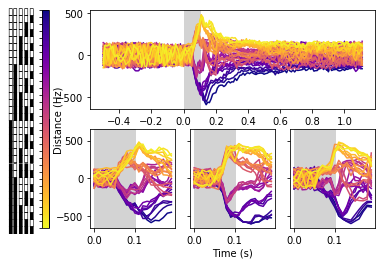

In [18]:
fig = plt.figure()
gs = GridSpec(1, 1)
xs = np.arange(-.5, 1.12, 1/100)

distance_plots(fig, gs[0], xs, [closests1, closests2, closests3])


32
32
32
32


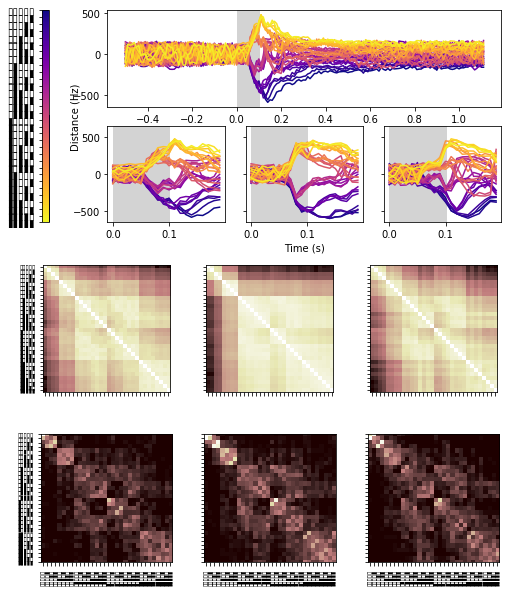

In [19]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(8, 3, hspace=1)
# distance_ax1 = fig.add_subplot(gs[0, :2])
# distance_ax1_zoom = fig.add_subplot(gs[0, 2:])
# distance_ax2 = fig.add_subplot(gs[1, :2])
# distance_ax2_zoom = fig.add_subplot(gs[1, 2:])
# distance_ax3 = fig.add_subplot(gs[2, :2])
# distance_ax3_zoom = fig.add_subplot(gs[2, 2:])
xs = np.arange(-.5, 1.12, 1/100)
# plot_1d_distance_graph(xs, closests1, distance_ax1)
# plot_1d_distance_graph(xs[50:70], closests1[50:70], distance_ax1_zoom)
# plot_1d_distance_graph(xs, closests2, distance_ax2)
# plot_1d_distance_graph(xs[50:70], closests2[50:70], distance_ax2_zoom)
# plot_1d_distance_graph(xs, closests3, distance_ax3)
# plot_1d_distance_graph(xs[50:70], closests3[50:70], distance_ax3_zoom)
distance_plots(fig, gs[:3, :], xs, [closests1, closests2, closests3])

dm_ax1 = fig.add_subplot(gs[3:5, 0])
dm_ax2 = fig.add_subplot(gs[3:5, 1])
dm_ax3 = fig.add_subplot(gs[3:5, 2])
dm_ax1.imshow(dm_avg1, cmap='pink_r')
dm_ax2.imshow(dm_avg2, cmap='pink_r')
dm_ax3.imshow(dm_avg3, cmap='pink_r')
dm_ax1.set_yticks(range(32))
dm_ax1.set_yticklabels(glyphs, fontsize=6)
dm_ax2.set_yticks(range(32))
dm_ax3.set_yticks(range(32))
dm_ax2.set_yticklabels([])
dm_ax3.set_yticklabels([])
dm_ax1.set_xticks(range(32))
dm_ax2.set_xticks(range(32))
dm_ax3.set_xticks(range(32))
dm_ax1.set_xticklabels([])#glyphs, rotation=90);
dm_ax2.set_xticklabels([])#glyphs, rotation=90);
dm_ax3.set_xticklabels([])#glyphs, rotation=90);


# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax1.yaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax1.xaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax2.xaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax3.xaxis.get_ticklabels())]


dm_ax1.set_ylim(31.5, -.5)
dm_ax2.set_ylim(31.5, -.5)
dm_ax3.set_ylim(31.5, -.5)

cm_ax1 = fig.add_subplot(gs[5:7, 0])
cm_ax2 = fig.add_subplot(gs[5:7, 1])
cm_ax3 = fig.add_subplot(gs[5:7, 2])
cm_ax1.imshow(cm1, cmap='pink')
cm_ax2.imshow(cm2, cmap='pink')
cm_ax3.imshow(cm3, cmap='pink')
cm_ax1.set_yticks(range(32))
cm_ax1.set_yticklabels(glyphs, fontsize=6)
cm_ax2.set_yticks(range(32))
cm_ax2.set_yticklabels([])
cm_ax3.set_yticks(range(32));
cm_ax3.set_yticklabels([]);
cm_ax1.set_xticks(range(32))
cm_ax1.set_xticklabels(glyphs, rotation=90, fontsize=6)
cm_ax2.set_xticks(range(32))
cm_ax2.set_xticklabels(glyphs, rotation=90, fontsize=6)
cm_ax3.set_xticks(range(32))
cm_ax3.set_xticklabels(glyphs, rotation=90, fontsize=6);
plt.savefig('230116_fig2.pdf')
